In [7]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [8]:
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [9]:
# Batch size during training
batch_size = 128

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Dimensions for generator
gen_input = 100
gen_output = 784

# Dimensions for Discriminator
dis_input = 784
dis_output = 1

In [10]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return dset.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

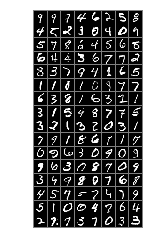

In [12]:
dataiter = iter(data_loader)
images = dataiter.next()
imshow(vutils.make_grid(images[0]))

In [13]:
class Discriminator(nn.Module):
    
    def __init__(self, n_features, n_out):
        super(Discriminator, self).__init__()
        self.n_features = n_features
        self.n_out = n_out
        
        self.layer_1 = nn.Sequential(nn.Linear(self.n_features, 1024),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3))
        self.layer_2 = nn.Sequential(nn.Linear(1024, 512),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3))
        self.layer_3 = nn.Sequential(nn.Linear(512, 256),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3))
        self.out = nn.Sequential(nn.Linear(256, self.n_out),
                                     nn.Sigmoid())
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.out(x)
        return x
        

In [14]:
class Generator(nn.Module):
    
    def __init__(self, n_features, n_out):
        super(Generator, self).__init__()
        self.n_features = n_features
        self.n_out = n_out
        
        self.layer_1 = nn.Sequential(nn.Linear(self.n_features, 256),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3))
        self.layer_2 = nn.Sequential(nn.Linear(256, 512),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3))
        self.layer_3 = nn.Sequential(nn.Linear(512, 1024),
                                     nn.LeakyReLU(0.2),
                                     nn.Dropout(0.3))
        self.out = nn.Sequential(nn.Linear(1024, self.n_out),
                                     nn.Tanh())
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.out(x)
        return x
        

In [15]:
discriminator = Discriminator(dis_input, dis_output)
generator = Generator(gen_input, gen_output)

In [16]:
# Define optimizer for Generator and Discriminator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Define Loss function for Generator and Disriminator
loss = nn.BCELoss()
test_noise = torch.randn(10, 100)

In [17]:
def train_discriminator(opt, real_data, fake_data):
    opt.zero_grad()
    
    # train real
    pred_real = discriminator(real_data)
    
    error_real = loss(pred_real, torch.ones(real_data.size(0), 1))
    error_real.backward()
    
    # train fake
    pred_fake = discriminator(fake_data)
    error_fake = loss(pred_fake, torch.zeros(fake_data.size(0), 1))
    error_fake.backward()
    
    opt.step()
    return error_real + error_fake, pred_real, error_fake

In [18]:
def train_generator(opt, fake_data):
    opt.zero_grad()
    
    pred = discriminator(fake_data)
    error = loss(pred, torch.ones(fake_data.size(0), 1))
    error.backward()
    
    opt.step()
    return error

In [28]:
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
            N = real_batch.size(0)
            # 1. Train Discriminator
            real_data = real_batch.view(N, 1 * 28 * 28)
            # Generate fake data and detach 
            # So gradients are not calculated for generator
            fake_data = generator(torch.randn(N,100)).detach()
            # Train D
            d_error, d_pred_real, d_pred_fake = \
                  train_discriminator(d_optimizer, real_data, fake_data)

            # 2. Train Generator
            # Generate fake data
            fake_data = generator(torch.randn(N,100))
            # Train G
            g_error = train_generator(g_optimizer, fake_data)
            if (n_batch) % 100 == 0:
                test_images = generator(test_noise).view(test_noise.size(0), 1, 28, 28)
                test_images = test_images.data

In [19]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [52]:
# Save the generator model's state
torch.save({'state_dict': generator.state_dict()}, 'checkpoint.pth.tar')

In [23]:
# Load the saved generator
model = Generator(100, 784)
checkpoint = torch.load('checkpoint.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

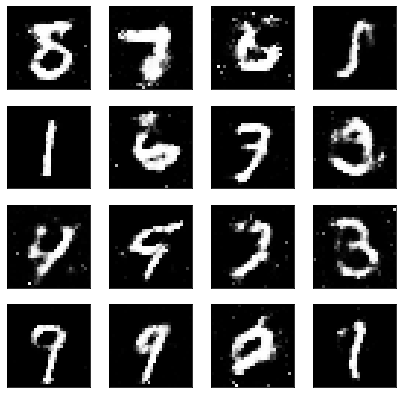

In [25]:
# Test the generator
model.eval()
fake_data = model(torch.randn(16,100))
fake_data = fake_data.view(fake_data.size(0), 1, 28, 28)
view_samples(0, [fake_data])